<a href="https://colab.research.google.com/github/royarkaofficial/DataOps-Case-Study-Assignment-15th_Jan/blob/main/Case_Study_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement: E-Commerce Customer Purchase Prediction

You are working as a Data Scientist for an e-commerce company aiming to enhance customer experience and predict customer behaviour. The business goal is to predict whether a customer will make a purchase during their next visit based on their past interactions and demographics. This prediction can help the marketing team identify potential buyers and design targeted campaigns.

Dataset Description:

The dataset contains customer interaction data, including demographics, purchase history, browsing behavior, and feedback text. The features are as follows:

CustomerID: Unique identifier for the customer.

Age: Age of the customer.

Gender: Gender of the customer (e.g., Male, Female).

AnnualIncome: Customer's yearly income in USD.

LastPurchaseAmount: Amount spent in the last purchase (in USD).

BrowsingTime: Time spent browsing the e-commerce site during the last session (in minutes).

Feedback: Customer feedback or comments on the website experience.

Region: Region where the customer is located.
Purchased: Target variable (1 = Purchased, 0 = Not Purchased).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

Data Cleaning and Preprocessing Steps:

1. Handling Missing Values

a) Numeric Columns:

Impute missing values using mean or median for columns like Age, AnnualIncome, and LastPurchaseAmount.

b) Categorical Columns:

Replace missing values in Gender and Region with the mode or Unknown.

c) Text Column (Feedback):

Fill missing values with "No Feedback".

In [3]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSV Files/ecommerce_customer_data.csv')
data

,CustomerID,Age,Gender,AnnualIncome,LastPurchaseAmount,BrowsingTime,Feedback,Region,Purchased
0,CUST0001,56.0,Female,74340.0,246.447653,82.098824,No stock,East,1
1,CUST0002,69.0,female,NaN,243.877231,91.467115,Great service!,East,0
2,CUST0003,46.0,female,98832.0,1301.928501,71.881010,No stock,North,0
3,CUST0004,32.0,M,71293.0,1494.629310,57.117566,NaN,north,0
4,CUST0005,60.0,Male,115981.0,1170.903843,50.009069,Amazing deals,East,0
...,...,...,...,...,...,...,...,...,...
250,CUST0224,66.0,F,60262.0,350.066299,118.143860,Poor experience,South,0
251,CUST0245,28.0,male,24748.0,277.485207,109.815022,NaN,East,0
252,CUST0199,20.0,F,97052.0,732.533770,41.676265,No stock,south,1
253,CUST0046,26.0,M,69115.0,1372.615033,17.573377,Poor experience,South,0


In [5]:
import pandas as pd
# Assuming your data is stored in a DataFrame called 'data'
# Step 1: Handle missing values in numeric columns (Age, AnnualIncome, LastPurchaseAmount)
data['Age'] = data['Age'].fillna(data['Age'].mean())  # Impute missing Age with mean
data['AnnualIncome'] = data['AnnualIncome'].fillna(data['AnnualIncome'].mean())  # Impute missing AnnualIncome with mean
data['LastPurchaseAmount'] = data['LastPurchaseAmount'].fillna(data['LastPurchaseAmount'].median())  # Impute missing LastPurchaseAmount with median

# Step 2: Handle missing values in categorical columns (Gender, Region)
data['Gender'] = data['Gender'].fillna(data['Gender'].mode()[0])  # Impute missing Gender with mode
data['Region'] = data['Region'].fillna('Unknown')  # Impute missing Region with 'Unknown'

# Step 3: Handle missing values in text column (Feedback)
data['Feedback'] = data['Feedback'].fillna('No Feedback')  # Impute missing Feedback with 'No Feedback'

# Print the cleaned data
print(data)

    CustomerID   Age  Gender   AnnualIncome  LastPurchaseAmount  BrowsingTime  \
0     CUST0001  56.0  Female   74340.000000          246.447653     82.098824   
1     CUST0002  69.0  female   90226.703863          243.877231     91.467115   
2     CUST0003  46.0  female   98832.000000         1301.928501     71.881010   
3     CUST0004  32.0       M   71293.000000         1494.629310     57.117566   
4     CUST0005  60.0    Male  115981.000000         1170.903843     50.009069   
..         ...   ...     ...            ...                 ...           ...   
250   CUST0224  66.0       F   60262.000000          350.066299    118.143860   
251   CUST0245  28.0    male   24748.000000          277.485207    109.815022   
252   CUST0199  20.0       F   97052.000000          732.533770     41.676265   
253   CUST0046  26.0       M   69115.000000         1372.615033     17.573377   
254   CUST0202  25.0  female   41677.000000          718.632485     71.245098   

            Feedback Region

2. Outlier Detection

Detect outliers in numeric features (AnnualIncome, LastPurchaseAmount, and BrowsingTime) using:

Z-scores: Remove values exceeding ±3 standard deviations.

IQR Method: Remove data outside 1.5 times the interquartile range.

Handle outliers by capping extreme values to the 5th and 95th percentiles.

In [6]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'data' is your DataFrame with numerical columns
# Define the numeric columns on which to perform outlier detection and handling
numeric_columns = ['AnnualIncome', 'LastPurchaseAmount', 'BrowsingTime']

# === Z-Score Method: Detect outliers using z-scores ===
# Calculate z-scores for the numeric columns
z_scores = np.abs(stats.zscore(data[numeric_columns]))

# Identify rows where any column has a z-score > 3 (considered an outlier)
z_outliers = (z_scores > 3).any(axis=1)

# Remove rows with z-score > 3 in any column
data_no_z_outliers = data[~z_outliers]

# === IQR Method: Detect outliers using the interquartile range (IQR) ===
# Calculate the 1st quartile (Q1) and 3rd quartile (Q3) for each numeric column
Q1 = data[numeric_columns].quantile(0.25)
Q3 = data[numeric_columns].quantile(0.75)

# Compute the IQR for each column
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows where any value is outside the IQR bounds
iqr_outliers = ((data[numeric_columns] < lower_bound) | (data[numeric_columns] > upper_bound)).any(axis=1)

# Remove rows with outliers based on IQR
data_no_iqr_outliers = data[~iqr_outliers]

# === Capping extreme values: Handling outliers by limiting values to a defined range ===
# Calculate the 5th and 95th percentiles for each numeric column
percentiles = data[numeric_columns].quantile([0.05, 0.95])

# Create a copy of the original data for capping
data_capped = data.copy()

# Cap values outside the 5th and 95th percentiles
for col in numeric_columns:
    data_capped[col] = data_capped[col].clip(lower=percentiles.loc[0.05, col], upper=percentiles.loc[0.95, col])

# === Print the results of each method ===
print("Data after removing outliers based on Z-scores:")
print(data_no_z_outliers)

print("\nData after removing outliers based on IQR method:")
print(data_no_iqr_outliers)

print("\nData after capping extreme values to 5th and 95th percentiles:")
print(data_capped)

Data after removing outliers based on Z-scores:
    CustomerID   Age  Gender   AnnualIncome  LastPurchaseAmount  BrowsingTime  \
0     CUST0001  56.0  Female   74340.000000          246.447653     82.098824   
1     CUST0002  69.0  female   90226.703863          243.877231     91.467115   
2     CUST0003  46.0  female   98832.000000         1301.928501     71.881010   
3     CUST0004  32.0       M   71293.000000         1494.629310     57.117566   
4     CUST0005  60.0    Male  115981.000000         1170.903843     50.009069   
..         ...   ...     ...            ...                 ...           ...   
250   CUST0224  66.0       F   60262.000000          350.066299    118.143860   
251   CUST0245  28.0    male   24748.000000          277.485207    109.815022   
252   CUST0199  20.0       F   97052.000000          732.533770     41.676265   
253   CUST0046  26.0       M   69115.000000         1372.615033     17.573377   
254   CUST0202  25.0  female   41677.000000          718.6324

3. Standardization

Normalize numeric features (Age, AnnualIncome, LastPurchaseAmount, BrowsingTime) using:

MinMaxScaler: Scales values between 0 and 1.

StandardScaler: Standardizes data to have zero mean and unit variance.

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define the numeric columns that need to be scaled
numeric_columns = ['Age', 'AnnualIncome', 'LastPurchaseAmount', 'BrowsingTime']

# === Initialize the scalers ===
# MinMaxScaler: Scales data to a range between 0 and 1 (or specified range)
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler() # StandardScaler: Standardizes data to have a mean of 0 and standard deviation of 1

# === Apply MinMaxScaler ===
data_minmax_scaled = data.copy() # Create a copy of the original DataFrame to store MinMax scaled values
data_minmax_scaled[numeric_columns] = min_max_scaler.fit_transform(data[numeric_columns])  # Transform the specified numeric columns using MinMaxScaler

# === Apply StandardScaler ===
data_standard_scaled = data.copy() # Create another copy of the original DataFrame to store Standard scaled values
data_standard_scaled[numeric_columns] = standard_scaler.fit_transform(data[numeric_columns]) # Transform the specified numeric columns using StandardScaler

# === Print the results ===
print("Data after MinMax Scaling:\n", data_minmax_scaled) # Print the data after MinMax Scaling
print("\nData after Standard Scaling:\n", data_standard_scaled) # Print the data after Standard Scaling

Data after MinMax Scaling:
     CustomerID       Age  Gender  AnnualIncome  LastPurchaseAmount  \
0     CUST0001  0.745098  Female      0.128980            0.105843   
1     CUST0002  1.000000  female      0.166977            0.104531   
2     CUST0003  0.549020  female      0.187558            0.644217   
3     CUST0004  0.274510       M      0.121693            0.742509   
4     CUST0005  0.823529    Male      0.228574            0.577385   
..         ...       ...     ...           ...                 ...   
250   CUST0224  0.941176       F      0.095310            0.158696   
251   CUST0245  0.196078    male      0.010370            0.121674   
252   CUST0199  0.039216       F      0.183301            0.353783   
253   CUST0046  0.156863       M      0.116484            0.680273   
254   CUST0202  0.137255  female      0.050860            0.346692   

     BrowsingTime         Feedback Region  Purchased  
0        0.225413         No stock   East          1  
1        0.251631   G

4. Handling Text Features (Bag of Words)

Extract features from the Feedback column using the Bag of Words approach or TF-IDF Vectorization for numerical representation.

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# === Define the text column to be processed ===
text_column = 'Feedback' # 'Feedback' is the column in the DataFrame containing text data

# === Initialize vectorizers ===
# CountVectorizer: Converts text into a Bag of Words (BoW) representation.
# 'stop_words="english"' removes common English stop words (e.g., "the", "is", "and").
vectorizer_bow = CountVectorizer(stop_words='english')

# TfidfVectorizer: Converts text into TF-IDF features, capturing term importance in the document.
# 'stop_words="english"' similarly removes common English stop words.
vectorizer_tfidf = TfidfVectorizer(stop_words='english')

# === Transform the text data into numerical representations ===
# Fit the vectorizer to the text data and transform it into a sparse matrix for BoW
bow_features = vectorizer_bow.fit_transform(data[text_column])

# Fit the vectorizer to the text data and transform it into a sparse matrix for TF-IDF
tfidf_features = vectorizer_tfidf.fit_transform(data[text_column])

# === Convert sparse matrices to dense DataFrames for readability ===
# Convert the Bag of Words sparse matrix to a DataFrame with column names as feature names
bow_df = pd.DataFrame(bow_features.toarray(), columns=vectorizer_bow.get_feature_names_out())

# Convert the TF-IDF sparse matrix to a DataFrame with column names as feature names
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

# === Print the transformed features for inspection ===
print("Bag of Words Features:\n", bow_df)
print("\nTF-IDF Features:\n", tfidf_df)

Bag of Words Features:
      amazing  deals  experience  feedback  great  poor  service  stock
0          0      0           0         0      0     0        0      1
1          0      0           0         0      1     0        1      0
2          0      0           0         0      0     0        0      1
3          0      0           0         1      0     0        0      0
4          1      1           0         0      0     0        0      0
..       ...    ...         ...       ...    ...   ...      ...    ...
250        0      0           1         0      0     1        0      0
251        0      0           0         1      0     0        0      0
252        0      0           0         0      0     0        0      1
253        0      0           1         0      0     1        0      0
254        0      0           0         0      1     0        1      0

[255 rows x 8 columns]

TF-IDF Features:
       amazing     deals  experience  feedback     great      poor   service  \
0 

5. Checking for Inconsistencies

Standardize inconsistent categorical entries:

Example: Convert Male, M, and male to Male.

Ensure proper formats for structured data like Age (e.g., integers only).

In [10]:
import pandas as pd
# Assuming 'data' is your DataFrame
# === Standardize the Gender column ===
# Replace inconsistent gender labels with standardized values
data['Gender'] = data['Gender'].replace({
    'M': 'Male',      # Replace 'M' with 'Male'
    'male': 'Male',   # Replace 'male' with 'Male'
    'Female': 'Female',  # Keep 'Female' as it is
    'female': 'Female'   # Replace 'female' with 'Female'
})

# === Clean the Age column ===
# Convert the Age column to numeric values and Invalid entries (e.g., non-numeric or invalid data) will be converted to NaN
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

# Handle missing or invalid Age values (now represented as NaN) and Replace NaN values with the mean of the Age column
# Alternatively, you could use another imputation strategy, such as median or a fixed value
data['Age'] = data['Age'].fillna(data['Age'].mean())

# === Print the cleaned data ===
print("Data after standardizing Gender and cleaning Age:")
print(data)

Data after standardizing Gender and cleaning Age:
    CustomerID   Age  Gender   AnnualIncome  LastPurchaseAmount  BrowsingTime  \
0     CUST0001  56.0  Female   74340.000000          246.447653     82.098824   
1     CUST0002  69.0  Female   90226.703863          243.877231     91.467115   
2     CUST0003  46.0  Female   98832.000000         1301.928501     71.881010   
3     CUST0004  32.0    Male   71293.000000         1494.629310     57.117566   
4     CUST0005  60.0    Male  115981.000000         1170.903843     50.009069   
..         ...   ...     ...            ...                 ...           ...   
250   CUST0224  66.0       F   60262.000000          350.066299    118.143860   
251   CUST0245  28.0    Male   24748.000000          277.485207    109.815022   
252   CUST0199  20.0       F   97052.000000          732.533770     41.676265   
253   CUST0046  26.0    Male   69115.000000         1372.615033     17.573377   
254   CUST0202  25.0  Female   41677.000000          718.63

6. Checking for Duplicates

Identify and remove duplicate records based on CustomerID or identical rows in all columns.

In [11]:
import pandas as pd
# Remove duplicates based on 'CustomerID' (keep first occurrence)
data_no_duplicates_customerid = data.drop_duplicates(subset='CustomerID')
# Remove duplicates across all columns (keep first occurrence)
data_no_duplicates_all = data.drop_duplicates()
print("Data after removing duplicates based on CustomerID:\n", data_no_duplicates_customerid)
print("\nData after removing all identical rows:\n", data_no_duplicates_all)

Data after removing duplicates based on CustomerID:
     CustomerID        Age  Gender   AnnualIncome  LastPurchaseAmount  \
0     CUST0001  56.000000  Female   74340.000000          246.447653   
1     CUST0002  69.000000  Female   90226.703863          243.877231   
2     CUST0003  46.000000  Female   98832.000000         1301.928501   
3     CUST0004  32.000000    Male   71293.000000         1494.629310   
4     CUST0005  60.000000    Male  115981.000000         1170.903843   
..         ...        ...     ...            ...                 ...   
245   CUST0246  34.000000  Female  106769.000000          136.116191   
246   CUST0247  43.473913    Male   29435.000000         1980.020862   
247   CUST0248  43.473913    Male   23709.000000          651.484151   
248   CUST0249  22.000000  Female  143961.000000         1621.650147   
249   CUST0250  69.000000       F   50355.000000          516.734903   

     BrowsingTime        Feedback Region  Purchased  
0       82.098824        No 

7. Export the Cleaned Dataset

Save the cleaned dataset to a file (e.g., CSV or Excel) for reproducibility and future use.

In [12]:
# Save the cleaned dataset to a CSV file
data_no_duplicates_customerid.to_csv('cleaned_dataset.csv', index=False)  # Exclude row index
print("Cleaned dataset saved to 'cleaned_dataset.csv'")

Cleaned dataset saved to 'cleaned_dataset.csv'


Model Training:

1. Data Splitting

Split the cleaned dataset into training and testing sets (e.g., 80% train, 20% test).


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the cleaned dataset (CSV file)
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSV Files/cleaned_dataset.csv')

# Define the features (X) and target variable (y)
X = data.drop(columns=['Purchased', 'CustomerID', 'Feedback'])  # Drop target and non-relevant columns
y = data['Purchased']  # Target variable (Purchased)

# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the size of the splits
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 200 samples
Testing set size: 50 samples


2. Model Selection

Train a classification model to predict Purchased:

Logistic Regression

Random Forest

Gradient Boosting (e.g., XGBoost)

Support Vector Machine (SVM)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import xgboost as xgb

# === Load the cleaned dataset ===
# Load the dataset from a CSV file. Adjust the path as necessary.
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSV Files/cleaned_dataset.csv')

# === Preprocess the data ===
# Convert categorical variables to numeric using One-Hot Encoding
# 'drop_first=True' avoids multicollinearity by removing the first level of each category
data = pd.get_dummies(data, columns=['Gender', 'Region'], drop_first=True)

# Define the feature matrix (X) and target variable (y)
X = data.drop(columns=['Purchased', 'CustomerID', 'Feedback'])  # Exclude the target and irrelevant columns
y = data['Purchased']  # Target variable indicating whether a customer purchased or not

# Use an 80-20 split for training and testing, with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Train and evaluate models ===
# 1. Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)  # Increase max_iter for convergence
log_reg_model.fit(X_train, y_train)
log_reg_pred = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)  # Compute accuracy

# 2. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)  # Random Forest with default hyperparameters
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)  # Compute accuracy

# 3. Gradient Boosting (XGBoost)
xgb_model = xgb.XGBClassifier(random_state=42)  # Gradient boosting with XGBoost
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)  # Compute accuracy

# 4. Support Vector Machine (SVM)
svm_model = SVC(random_state=42)  # Support Vector Classifier with default settings
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)  # Compute accuracy

# === Print the results ===
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.9f}")
print(f"Random Forest Accuracy: {rf_accuracy:.9f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.9f}")
print(f"SVM Accuracy: {svm_accuracy:.9f}")

Logistic Regression Accuracy: 0.580000000
Random Forest Accuracy: 0.420000000
XGBoost Accuracy: 0.460000000
SVM Accuracy: 0.480000000


3. Model Evaluation

Evaluate the model on the test set using:

Accuracy

Precision, Recall, F1 Score

Area Under the Curve (AUC) for ROC.


Model: Logistic Regression
Accuracy: 0.5800
Precision: 0.6154
Recall: 0.5926
F1 Score: 0.6038
AUC (ROC): 0.5813
----------------------------------------


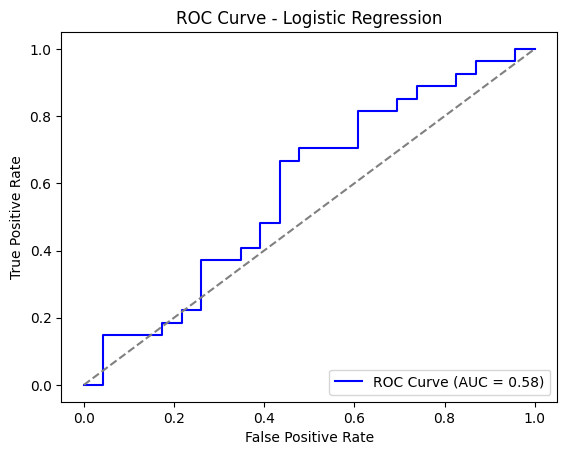

Model: Random Forest
Accuracy: 0.4200
Precision: 0.4615
Recall: 0.4444
F1 Score: 0.4528
AUC (ROC): 0.4420
----------------------------------------


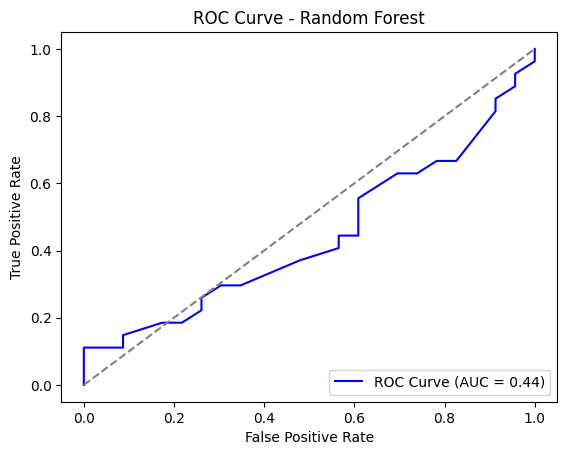

Model: XGBoost
Accuracy: 0.4600
Precision: 0.5000
Recall: 0.4444
F1 Score: 0.4706
AUC (ROC): 0.4074
----------------------------------------


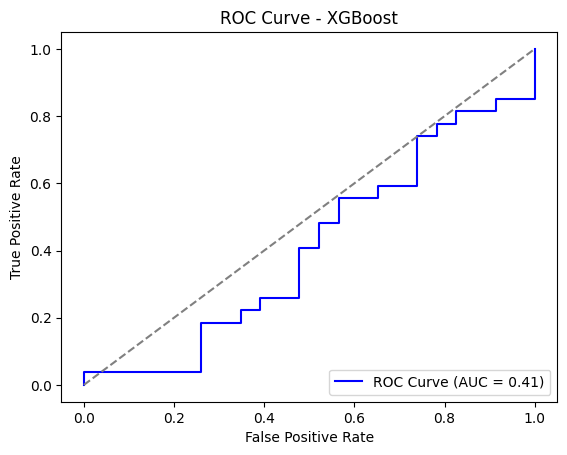

Model: SVM
Accuracy: 0.4800
Precision: 0.5294
Recall: 0.3333
F1 Score: 0.4091
AUC (ROC): 0.4976
----------------------------------------


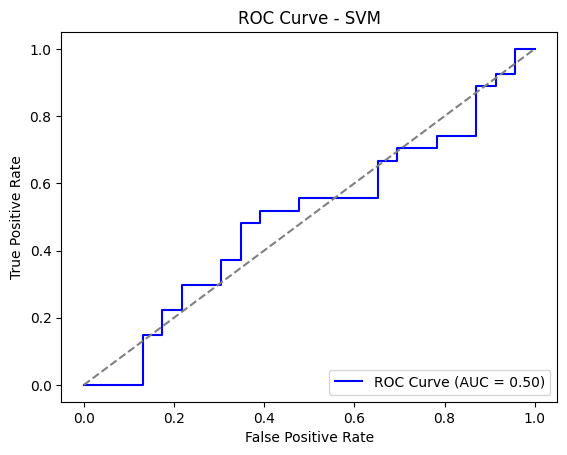

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt

# === Load the cleaned dataset ===
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSV Files/cleaned_dataset.csv')

# === Preprocess the data ===
# Convert categorical variables ('Gender', 'Region') to numeric using One-Hot Encoding
# 'drop_first=True' removes the first category to avoid multicollinearity
data = pd.get_dummies(data, columns=['Gender', 'Region'], drop_first=True)

# Define the feature matrix (X) and target variable (y)
X = data.drop(columns=['Purchased', 'CustomerID', 'Feedback'])  # Exclude non-relevant columns and the target
y = data['Purchased']  # Target variable indicating purchase (binary classification)

# === Split the dataset ===
# Split data into training (80%) and testing (20%) subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Initialize models ===
# Dictionary to store model instances for comparison
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)  # Enable probability estimates for AUC/ROC
}

# === Evaluate each model ===
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Use probabilities for the positive class (ROC/AUC)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Display the evaluation metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC (ROC): {auc:.4f}")
    print("-" * 40)

    # === Plot the ROC Curve ===
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Plot the curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Baseline for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()